In [4]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

import matplotlib.pyplot as plt
plt.style.use('./cfg/my_custom_plot.mplstyle')

# use these lines on top of your matplotlib script
import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=4):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator        
 
# Now use matplotlib as usual.       
import matplotlib.pyplot as plt
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True


from utils import load_dataset, load_keys, ParticleCode


In [6]:
# Load PDG Codes
pdg_tab = ParticleCode()

plot_dir = './plots-gk/'
# Load datasets 
n_files = 10
location = "nersc"
df=load_dataset(n_files,'nersc')

Openning MiniRun 5 beta 2.a CAFs
Reading  10  files
Reading /global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.caf.beta2a/CAF.flat/0000000/MiniRun5_1E19_RHC.caf.0000000.CAF.flat.root
Reading /global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.caf.beta2a/CAF.flat/0000000/MiniRun5_1E19_RHC.caf.0000001.CAF.flat.root
Reading /global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.caf.beta2a/CAF.flat/0000000/MiniRun5_1E19_RHC.caf.0000002.CAF.flat.root
Reading /global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.caf.beta2a/CAF.flat/0000000/MiniRun5_1E19_RHC.caf.0000004.CAF.flat.root
Reading /global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.caf.beta2a/CAF.flat/0000000/MiniRun5_1E19_RHC.caf.0000005.CAF.flat.root
Reading /global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRu

In [3]:
class track_length():

    def __init__(self,pdg_code):

        self.pdg = pdg_code 
        self.start_x = []
        self.start_y = []
        self.start_z = []
        self.end_x = []
        self.end_y = []
        self.end_z = []

        self.lenghts=[]

    def update_data(self,data):
        ev_pdgs = data['rec.common.ixn.dlp.part.dlp.pdg']
        mask = np.isin(ev_pdgs,self.pdg)
        masked_pdgs = ev_pdgs[mask]
        if(len(masked_pdgs)==0):
            pass
        else:
            self.start_x.extend(data['rec.common.ixn.dlp.part.dlp.start.x'][mask])
            self.start_y.extend(data['rec.common.ixn.dlp.part.dlp.start.y'][mask])
            self.start_z.extend(data['rec.common.ixn.dlp.part.dlp.start.z'][mask])
            self.end_x.extend(data['rec.common.ixn.dlp.part.dlp.end.x'][mask])
            self.end_y.extend(data['rec.common.ixn.dlp.part.dlp.end.y'][mask])
            self.end_z.extend(data['rec.common.ixn.dlp.part.dlp.end.z'][mask])
            #calculate the lenght of the track
            lenght=np.sqrt((np.array(self.start_x) - np.array(self.end_x))**2 + (np.array(self.start_y) - np.array(self.end_y))**2 + (np.array(self.start_z) - np.array(self.end_z))**2)
            self.lenghts.extend(lenght)
            

In [12]:
proton_data = track_length(pdg_tab.proton)

for ev in range(len(df)):
    ev_data = df.iloc[ev]
    proton_data.update_data(ev_data)
    
    if(ev%1000==0):
        print(f"Processing event {ev}")

Processing event 0
Processing event 1000
Processing event 2000


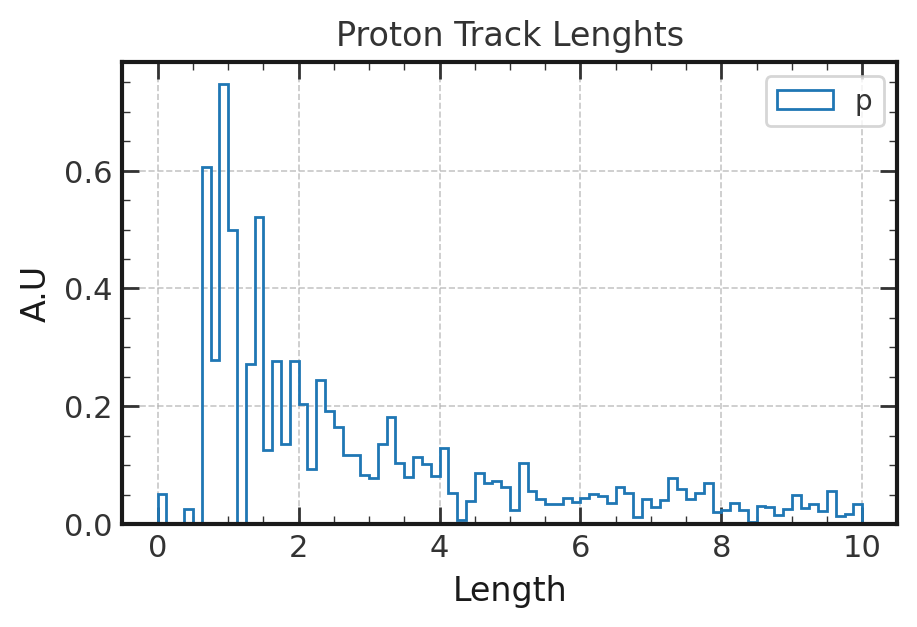

In [14]:
nbins=80
xrange=(0,10)
plt.hist(proton_data.lenghts,bins=nbins,histtype='step',density=True,label=r'p',range=xrange)
plt.legend()
plt.title('Proton Track Lenghts')
plt.xlabel('Length')
plt.ylabel('A.U')
plt.show()


### Distance of the proton to the vertex

Select one event, lets say event 15. This event has 3 interactions/vertices. We find the particles of this interactions/vertices. Then, we check if any of the particles are protons. If they are, keep it and save its positions. Then, find the distance vertex-position.  

In [17]:
class distance_particle_vertex():

    def __init__(self,pdg_code):
        self.pdg=pdg_code
        self.distances=[]

    def update_data(self, df_test):
        #df_test=df.iloc[event] #select event 15 del dataset, o sea, row 15
        #check the number of vertices in the event
        n_vertices=len(df_test['rec.common.ixn.dlp.vtx.x']) #num of vertices
        if n_vertices!= 0:
            print(f'Event {event} has {n_vertices} vertices \n')
        #check how many particles we have per vertices on event 15
        for vtx in range(0, n_vertices):
            n_particles = df_test['rec.common.ixn.dlp.part.dlp..length'][vtx]
            print('-----------------------------------------------')
            print(f'Vertex {vtx} has {n_particles} reco particles')
            #check if it's a proton
            #first, do luis's trick to scam the particles
            if vtx==0:
                n_pred= 0
            else: 
                n_pred=np.sum(df_test['rec.common.ixn.dlp.part.dlp..length'][:vtx])
            #for each vertex, check its particles
            for ip in range(n_pred,n_pred + n_particles):
                reco_pdg = df_test['rec.common.ixn.dlp.part.dlp.pdg'][ip]
                print(f"Particle {ip} is a {reco_pdg}")
                if reco_pdg==self.pdg:
                    #if it's a proton, save the distance to the vertex 
                    distance_to_vertex= np.sqrt(
                        (df_test['rec.common.ixn.dlp.part.dlp.start.x'][ip] -df_test['rec.common.ixn.dlp.vtx.x'][vtx] )**2 +
                        (df_test['rec.common.ixn.dlp.part.dlp.start.y'][ip] - df_test['rec.common.ixn.dlp.vtx.y'][vtx])**2 + 
                        (df_test['rec.common.ixn.dlp.part.dlp.start.z'][ip] - df_test['rec.common.ixn.dlp.vtx.z'][vtx])**2
                        )
                    print(distance_to_vertex)
                    self.distances.append(distance_to_vertex)

Event 1 has 2 vertices 

-----------------------------------------------
Vertex 0 has 1 reco particles
Particle 0 is a 2212
0.0
-----------------------------------------------
Vertex 1 has 17 reco particles
Particle 1 is a 22
Particle 2 is a 22
Particle 3 is a 22
Particle 4 is a 11
Particle 5 is a 22
Particle 6 is a 22
Particle 7 is a 22
Particle 8 is a 11
Particle 9 is a 2212
57.595937422616664
Particle 10 is a 211
Particle 11 is a 2212
53.614741120079316
Particle 12 is a 211
Particle 13 is a 211
Particle 14 is a 211
Particle 15 is a 211
Particle 16 is a 211
Particle 17 is a 2212
56.29608619662701
Event 3 has 1 vertices 

-----------------------------------------------
Vertex 0 has 1 reco particles
Particle 0 is a 13
Event 5 has 2 vertices 

-----------------------------------------------
Vertex 0 has 2 reco particles
Particle 0 is a 11
Particle 1 is a 13
-----------------------------------------------
Vertex 1 has 1 reco particles
Particle 2 is a 13
Event 8 has 1 vertices 

---------

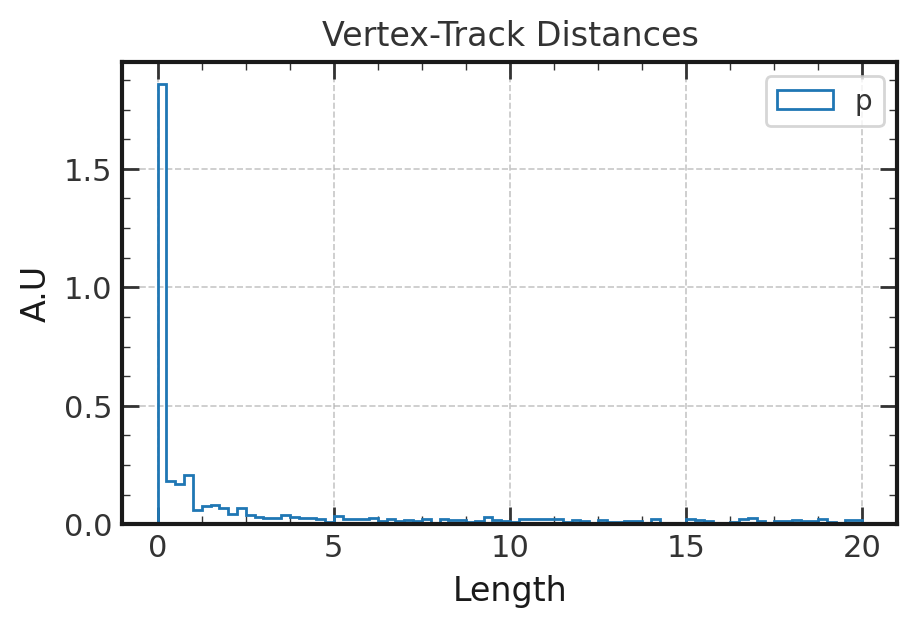

In [21]:
proton_data = distance_particle_vertex(pdg_tab.proton)

for event in range(len(df)):
    event_data = df.iloc[event]
    proton_data.update_data(event_data)


    if(ev%1000==0):
        print(f"Processing event {ev}")

nbins=80
xrange=[0,20]
plt.hist(proton_data.distances,bins=nbins,histtype='step',density=True,label=r'p', range=xrange)
plt.legend()
plt.title('Vertex-Track Distances')
plt.xlabel('Length')
plt.ylabel('A.U')
plt.show()